In [1]:
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans #聚类模块
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [16]:
infos = [
    {
        'name': chr(9311 + 1),
        "OS": 'win-15s',
        "idx": [9487,12077,12381]
    },
    {
        'name': chr(9311 + 2),
        "OS": 'mac-15s',
        "idx": [9487, 12383, 1145]
    },
    # {
    #     'name': chr(9311 + 3),
    #     "OS": 'mac-15s',
    #     "idx": [9487, 12383, 1145]
    # }
]

In [17]:
dfs = []
for x in infos:
    OS = x['OS']
    idx = x['idx']
    df = pd.read_pickle(f'./output/df_performance-{OS}-0924.pkl.zstd', compression='zstd')
    df_webgl = df[~df.webgl_time.isna()].copy()
    print(df_webgl[df_webgl['frames_count'].apply(lambda x: len(x)) == 2])
    df_webgl.loc[idx, 'frames_count'] = df_webgl.loc[idx]['frames_count'].map(lambda x: [min(x)])
    df_webgl.frames_count = df_webgl.frames_count.apply(lambda x: min(600, max(x)))
    dfs.append(df_webgl)

      status  cpu_real  cpu_full  gpu_real  gpu_full  webgl_time   
1604      Ok  0.576317  0.861717  0.576562  0.689951    0.255781  \
3280      Ok  2.212492  2.356115  0.365792  0.385714    0.125522   
5272      Ok  2.418309  2.687784  3.280816  3.486913    1.895647   
5606      Ok  0.370656  0.577769  0.327018  0.455900    0.180585   
8481      Ok  0.751085  0.821201  0.071700  0.076889    0.000708   
9106      Ok  0.727628  0.804687  0.070498  0.074335    0.000781   
9419      Ok  0.779707  0.978167  0.392318  1.521384    1.380418   
9481      Ok  0.274990  0.324616  0.011635  0.012369    0.007948   
9487      Ok  1.223590  9.967346  9.762705  9.987876    9.742641   
10024     Ok  0.546701  0.694539  0.545221  0.600178    0.059421   
12077     Ok  0.880988  0.941275  0.043501  0.056589    0.002641   
12381     Ok  1.176711  1.567105  0.158312  0.436657    0.003014   
14386     Ok  1.739991  1.919689  0.719199  0.803291    0.614700   
18841     Ok  0.792420  0.856602  0.073465  0.08

In [18]:
def plot_cdf(arr, *args, ax, **kwargs):
    arr = np.sort(arr)
    y = np.arange(len(arr)) / float(len(arr))
    if ax is None:
        plt.plot(arr, y, *args, **kwargs)
    else:
        ax.plot(arr, y, *args, **kwargs)

Text(0, 0.5, 'CDF')

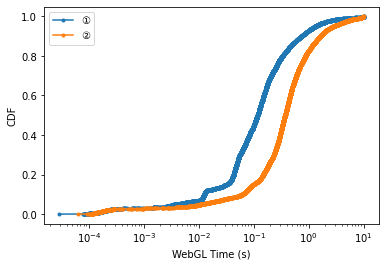

In [19]:
# cdf plot (line)
plt.xscale('log')
plot_cdf(dfs[0].webgl_time, '.-')
plot_cdf(dfs[1].webgl_time, '.-')
plt.legend([x['name'] for x in infos])
plt.xlabel('WebGL Time (s)')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

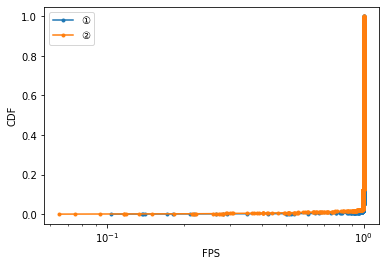

In [20]:
# cdf plot (line)
plt.xscale('log')
plot_cdf(dfs[0].frames_count / 600, '.-')
plot_cdf(dfs[1].frames_count / 600, '.-')
plt.legend([x['name'] for x in infos])
plt.xlabel('FPS')
plt.ylabel('CDF')

# Clustering

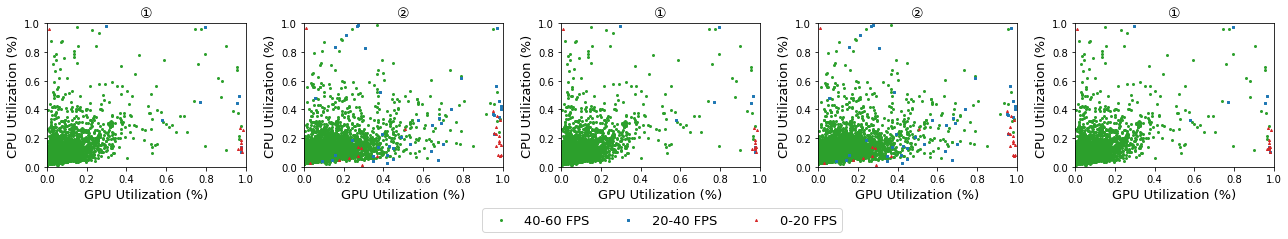

In [46]:
tmp_infos = infos + infos + [infos[0]]
tmp_dfs = dfs + dfs + [dfs[0]]
ax, fig = plt.subplots(1, len(tmp_infos), figsize=(18, 3))
for i, (info, df) in enumerate(zip(tmp_infos, tmp_dfs)):
    tmp_0_20 = (df['frames_count'] <= 200)
    tmp_20_40 = (df['frames_count'] > 200) & (df['frames_count'] <= 400)
    tmp_40_60 = (df['frames_count'] > 400)

    fig[i].scatter(x=df.loc[tmp_40_60, 'gpu_real'] / 10, y=df.loc[tmp_40_60, 'cpu_real'] / 10, s=4, marker='o', c='tab:green')
    fig[i].scatter(x=df.loc[tmp_20_40, 'gpu_real'] / 10, y=df.loc[tmp_20_40, 'cpu_real'] / 10, s=4, marker='s', c='tab:blue')
    fig[i].scatter(x=df.loc[tmp_0_20, 'gpu_real'] / 10, y=df.loc[tmp_0_20, 'cpu_real'] / 10, s=4, marker='^', c='tab:red')
    fig[i].set_xlim(0, 1)
    fig[i].set_ylim(0, 1)
    fig[i].set_title(info['name'], fontsize=14)
    fig[i].set_xlabel('GPU Utilization (%)', fontsize=13)
    fig[i].set_ylabel('CPU Utilization (%)', fontsize=13)
plt.tight_layout()
fig[0].legend(['40-60 FPS', '20-40 FPS', '0-20 FPS'], loc='lower center', bbox_to_anchor=(3.1, -0.5), ncol=3, fontsize=13)
plt.savefig(f'./output/figures/performance_distribution.pdf', bbox_inches='tight')

# 在性能不好的sample上做聚类 1

In [91]:
df_webgl_array = df_webgl_array_[[
    'frames_count',
    'js_real',
    # 'gpu_real',
    'webgl_time',
    # 'mem_mean_renderer',
    # 'mem_mean_gpu_process'
]]

<Axes: >

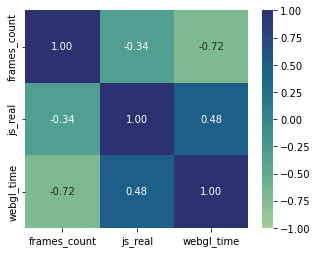

In [65]:
heatmap = df_webgl_array.corr()
plt.figure(figsize=(5,4))
sns.heatmap(heatmap, vmin=-1, vmax=1, square=False, annot=True, cbar=True, fmt='.2f', cmap='crest')

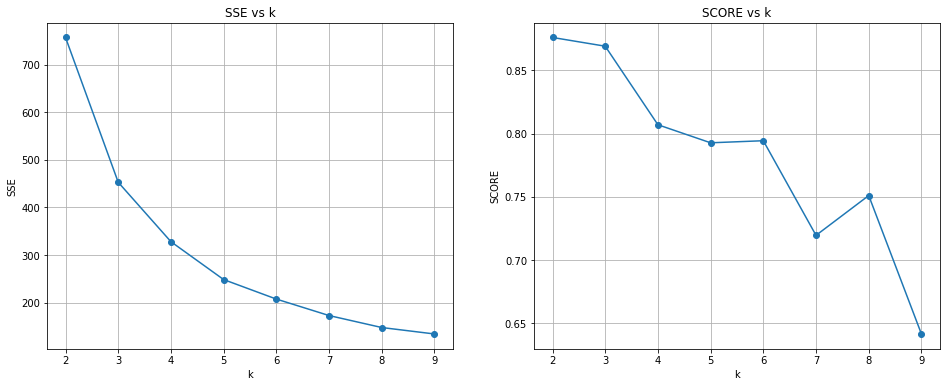

In [66]:
std = df_webgl_array.std(axis=0)
mean = df_webgl_array.mean(axis=0)
# std[0] = 480
# std[1:5] = 10
# mean[0:5] = 0
df_scaled = (df_webgl_array - mean) / std
df_scaled.fillna(0, inplace=True)

# df_scaled['frames_count'] = 0

SSE = []
SCORE = []
RANGE = range(2, 10)
for clusters in RANGE:
    km = KMeans(n_clusters=clusters, n_init='auto', random_state=42, max_iter=1000).fit(df_scaled)
    SSE.append(km.inertia_)
    score = silhouette_score(df_scaled, km.labels_, random_state=42)
    SCORE.append(score)
SSE = np.array(SSE)
SCORE = np.array(SCORE)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(RANGE, SSE, 'o-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(np.arange(min(RANGE), max(RANGE)+1, 1.0))
plt.grid(True)
plt.title('SSE vs k')
plt.subplot(1, 2, 2)
plt.plot(RANGE, SCORE, 'o-')
plt.xlabel('k')
plt.ylabel('SCORE')
plt.xticks(np.arange(min(RANGE), max(RANGE)+1, 1.0))
plt.grid(True)
plt.title('SCORE vs k')
plt.savefig('./output/figures/SSE_and_silhouette.png', bbox_inches='tight', dpi=300)

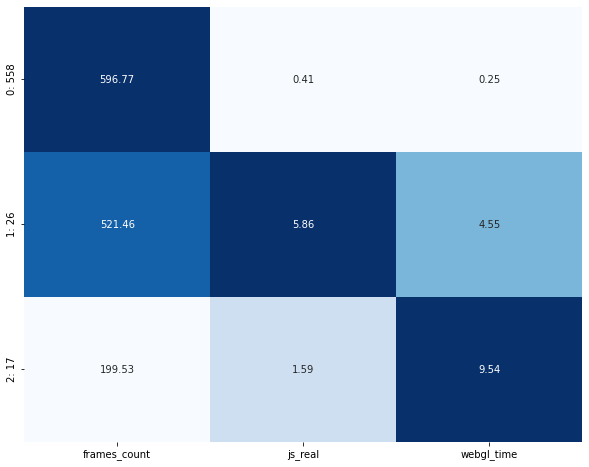

In [69]:
N = 3
km = KMeans(n_clusters=N, n_init='auto', random_state=42, max_iter=1000).fit(df_scaled)
center = km.cluster_centers_
center_min = center.min(axis=0)
center_max = center.max(axis=0)
center_01 = (center - center_min) / (center_max - center_min)
real_center = (center * std.values) + mean.values
# center_01[:, 0] = real_center[:, 0] / 480
# center_01[:, 1:4] = real_center[:, 1:4] / 8
# real_center_0_1 = (center - center.min(axis=0)) / (center.max(axis=0) - center.min(axis=0)) 
labels = km.labels_
num = pd.Series(labels).value_counts().sort_index().astype(str)
r = pd.concat([num, pd.DataFrame(real_center)], axis=1)
r.columns = ['num'] + list(df_webgl_array.columns)

plt.figure(figsize=(10,8))
sns.heatmap(center_01, vmin=0, vmax=1, square=False, annot=real_center, cbar=False, fmt='.2f', cmap='Blues', yticklabels=['{}: {}'.format(x,y) for x, y in zip(num.index, num.values)], xticklabels=df_webgl_array.columns) # type: ignore
plt.savefig('./output/figures/heatmap-complexity.pdf', bbox_inches='tight')
plt.savefig('./output/figures/heatmap-complexity.png', bbox_inches='tight', dpi=300)

# show some

bugs:
- 18896 https://www.alan-consortium.jp/  水波纹
- 27616 https://www.thesheldon.org/  
- 20307 5FPS?


In [116]:
df_scaled[labels==2].sample(10) * std.values + mean.values

,frames_count,js_real,gpu_real,webgl_time,mem_mean_renderer,mem_mean_gpu_process
4635,477.0,0.878062,1.438845,1.444285,319.567578,526.980859
16416,322.0,0.024868,2.186688,2.592323,721.815789,1704.659539
22372,478.0,0.479202,0.407747,0.352554,341.884766,1449.119336
14404,478.0,0.825306,0.361753,0.393383,993.038477,646.091797
7112,478.0,0.897347,0.644489,0.626752,289.325391,666.640820
17117,395.0,0.104738,0.006442,0.004826,825.885156,717.000000
13084,478.0,0.756712,0.752414,0.758485,428.424219,476.943945
15937,479.0,2.015007,0.266751,0.024260,206.930469,911.704297
12082,478.0,0.881988,0.602789,0.593916,580.528711,438.068359
21905,478.0,0.831560,2.552740,2.615166,156.311523,404.214844


In [117]:
df_scaled[labels==0].sample(10) * std.values + mean.values

,frames_count,js_real,gpu_real,webgl_time,mem_mean_renderer,mem_mean_gpu_process
3106,479.0,0.045739,0.027801,0.019402,168.884180,339.716602
7817,479.0,0.052971,0.014558,0.009862,154.501758,233.447461
5575,479.0,0.309204,0.138814,0.119067,285.129102,695.887500
16394,479.0,0.048180,0.014555,0.009692,157.475586,228.898828
18380,478.0,0.463639,0.244458,0.212311,149.813672,870.697852
4254,479.0,0.085435,0.064252,0.048782,148.182813,436.775781
15920,478.0,0.143373,0.171506,0.138757,152.801367,544.954883
11085,479.0,0.046478,0.014493,0.009693,160.041016,218.563477
11283,478.0,0.253738,0.178246,0.159148,142.881445,399.854688
22849,479.0,0.046231,0.019898,0.007034,197.029687,330.572461


In [24]:
df_scaled.loc[2936] * std.values + mean.values

frames_count            253.000000
js_real                   9.122356
render_real               0.001146
gpu_real                  2.195341
webgl_time                2.104758
mem_mean_gpu_process    251.711914
mem_mean_renderer       134.008008
Name: 2936, dtype: float64

In [25]:
df_label = df_scaled * std.values + mean.values
df_label['label'] = labels
df_label

,frames_count,js_real,render_real,gpu_real,webgl_time,mem_mean_gpu_process,mem_mean_renderer,label
2,580.0,0.298668,0.036227,0.463825,0.538061,870.302734,347.040820,0
11,596.0,0.320799,0.005974,0.695051,0.501488,424.297461,271.012305,0
15,597.0,0.408880,0.008894,1.170316,1.173689,490.459570,135.200781,0
17,595.0,2.004322,0.003805,2.512404,2.554558,1172.514648,1039.843164,2
20,599.0,0.509029,0.002604,0.486789,0.379705,554.161328,178.023633,0
...,...,...,...,...,...,...,...,...
29217,594.0,0.935317,0.085225,0.437793,0.400385,912.806836,634.661133,2
29219,597.0,0.461793,0.014106,0.478780,0.217637,516.396680,140.059570,0
29221,587.0,0.379386,0.007903,0.187927,0.161195,468.408594,220.606641,0
29224,594.0,0.289671,0.004740,0.162175,0.128084,409.140430,117.831250,0


In [26]:
df_label.loc[2936]

frames_count            253.000000
js_real                   9.122356
render_real               0.001146
gpu_real                  2.195341
webgl_time                2.104758
mem_mean_gpu_process    251.711914
mem_mean_renderer       134.008008
label                     2.000000
Name: 2936, dtype: float64